# Short-Term Electric Load Forecasting for Grid Demand Planning (Dummy Project for PLN Use Case)

📌 **Nama:** Difta Alzena Sakhi   
🎓 **Status**: Mahasiswa S1 Sains Data, UPN "Veteran" Jawa Timur   
🔗 **GitHub:** [github.com/diftaalzena1](https://github.com/diftaalzena1)  
📅 **Proyek Personal / Portfolio**  
🛠️ **Tools:** Python, Pandas, Seaborn, Scikit-Learn, Statsmodels  

---

## ✨ Deskripsi Proyek
Proyek ini membangun sistem prakiraan beban listrik harian berbasis data simulasi, meniru kebutuhan distribusi energi PLN. Model utama yang digunakan adalah **ARIMA**, didukung oleh regresi linier dan polinomial sebagai baseline. Validasi dilakukan dengan pendekatan evaluasi statis (snapshot) dan rolling forecast (backtesting), serta dibangun pipeline modular untuk simulasi operasional harian.

## 1. Import Library

Menyiapkan pustaka untuk analisis, modeling, dan visualisasi.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

## 2. Membuat Data Dummy Beban Listrik

Membuat simulasi realistis beban listrik harian berdasarkan pola musiman (fluktuasi tahunan), siklus mingguan (weekday vs weekend), dan noise acak.

**📌 Komponen Data Simulasi:**
- **Periode**: 1 Januari – 31 Desember 2024 (365 hari)
- **Rata-rata beban dasar**: 800 MW
- **Pola musiman**: Disimulasikan dengan fungsi sinus
- **Efek mingguan**: Beban lebih tinggi saat weekday
- **Noise acak**: Meniru ketidakpastian konsumsi harian

In [2]:
np.random.seed(42)
tanggal = pd.date_range(start="2024-01-01", periods=365, freq='D')

beban_rata2 = 800
musiman = 100 * np.sin(2 * np.pi * tanggal.dayofyear / 365)
mingguan = 50 * np.where(tanggal.dayofweek < 5, 1, 0.8)
noise = np.random.normal(0, 30, 365)

beban = beban_rata2 + musiman + mingguan + noise

df = pd.DataFrame({"Tanggal": tanggal, "Beban (MW)": beban})
df.set_index("Tanggal", inplace=True)
df.head()

,Beban (MW)
Tanggal,
2024-01-01,866.622760
2024-01-02,849.294232
2024-01-03,874.592623
2024-01-04,902.571138
2024-01-05,851.571879


In [3]:
# Simpan sebagai file CSV
df.to_csv("beban_listrik_dummy.csv")

## 3. Eksplorasi Data (EDA)

Memahami distribusi, pola waktu, dan stasioneritas data dummy beban listrik.

**a. Visualisasi tren waktu:**

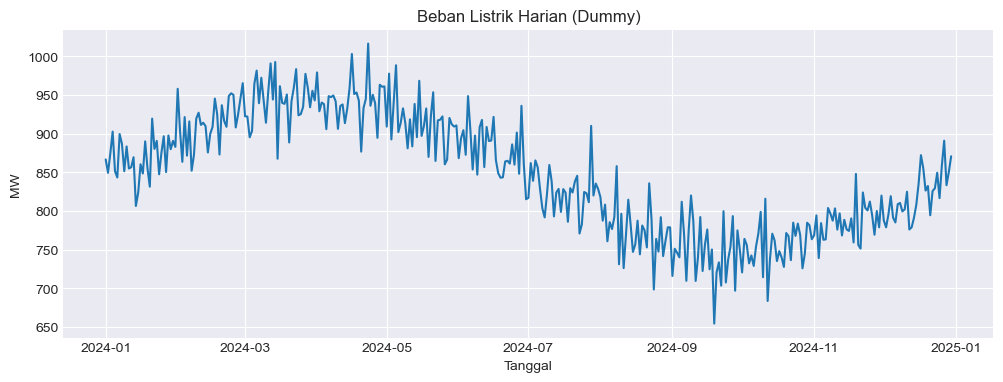

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["Beban (MW)"])
plt.title("Beban Listrik Harian (Dummy)")
plt.xlabel("Tanggal"); plt.ylabel("MW")
plt.show()

**Interpretasi:**

Visualisasi ini menunjukkan simulasi beban listrik harian sepanjang tahun, yang menggambarkan dinamika konsumsi energi di wilayah perkotaan seperti Surabaya. Beban listrik disimulasikan dengan mempertimbangkan faktor musiman, ritme mingguan, dan fluktuasi acak.

Poin penting yang dapat diamati:

- 📈 Pola musiman: Terdapat tren naik-turun sepanjang tahun yang menyerupai fluktuasi cuaca atau kebutuhan energi musiman (misal pendingin ruangan saat musim panas).   

- 📆 Siklus mingguan: Beban pada hari kerja (weekday) sedikit lebih tinggi dibanding akhir pekan, merefleksikan aktivitas industri dan perkantoran.   

- 🔄 Variasi harian alami: Fluktuasi acak menunjukkan bahwa meskipun terdapat pola, kebutuhan energi tetap berubah tiap hari—membutuhkan model prediksi yang adaptif.   

Simulasi ini merepresentasikan tantangan nyata yang dihadapi PLN dalam merencanakan distribusi energi: beban yang bersifat dinamis namun berpola. Dengan mengenali pola-pola ini, PLN dapat menyusun strategi pasokan daya yang lebih efisien dan andal.

**b. Distribusi bulanan (boxplot):**

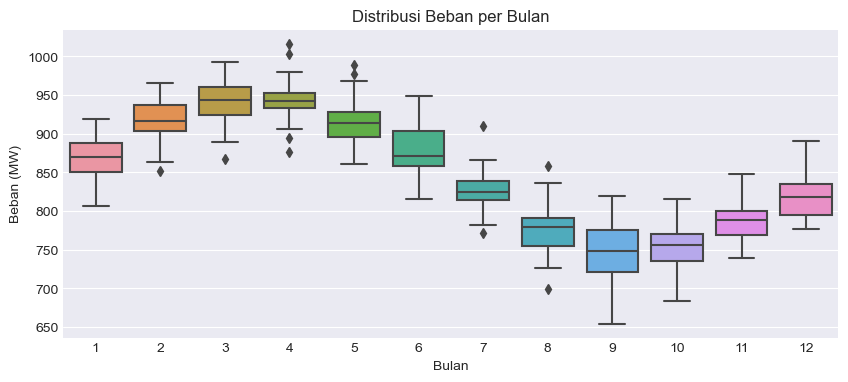

In [5]:
df["Bulan"] = df.index.month
plt.figure(figsize=(10, 4))
sns.boxplot(x="Bulan", y="Beban (MW)", data=df)
plt.title("Distribusi Beban per Bulan")
plt.show()

**Interpretasi:**   
Visualisasi boxplot ini menunjukkan distribusi beban listrik harian per bulan sepanjang tahun. Terlihat adanya pola musiman yang cukup jelas, dengan beban tinggi di awal tahun dan menurun pada pertengahan tahun, kemungkinan dipengaruhi oleh faktor cuaca atau aktivitas musiman masyarakat. Penyebaran nilai beban dan kehadiran outlier juga menandakan fluktuasi harian yang cukup dinamis—hal ini menuntut model prediksi yang tidak hanya akurat, tapi juga adaptif terhadap variasi musiman.

**c. Uji stasioneritas ADF**

ADF (Augmented Dickey-Fuller) digunakan untuk menguji apakah data time series memiliki akar unit (non-stasioner) atau tidak.

In [6]:
# Uji stasioneritas
adf = adfuller(df["Beban (MW)"])
print(f"ADF Stat: {adf[0]:.4f}, p-value: {adf[1]:.4f}")

ADF Stat: -0.9683, p-value: 0.7646


**Interpretasi:**
- Nilai p-value = 0.7646 jauh di atas ambang umum 0.05   
- Artinya, tidak cukup bukti untuk menolak hipotesis nol → data mengandung non-stasioneritas
- Ini sejalan dengan hasil EDA sebelumnya yang menunjukkan adanya tren dan musiman
- Karena tidak stasioner, maka diperlukan transformasi differencing untuk pemodelan ARIMA

Dengan demikian, model ARIMA akan menggunakan parameter d=1 dalam (p,d,q) untuk mengatasi tren dalam data.

**Plot ACF & PACF (post-differencing)**

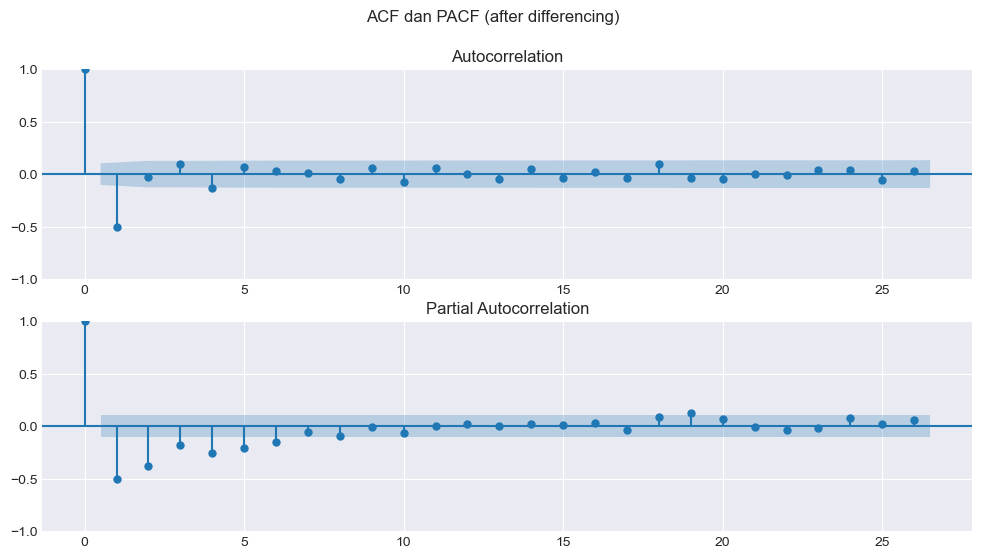

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df["Beban (MW)"].diff().dropna(), ax=ax[0])
plot_pacf(df["Beban (MW)"].diff().dropna(), ax=ax[1])
plt.suptitle("ACF dan PACF (after differencing)")
plt.show()

**Interpretasi ACF dan PACF setelah Differencing:**   
Plot ini menampilkan fungsi autokorelasi (ACF) dan autokorelasi parsial (PACF) dari data beban listrik setelah differencing untuk menghilangkan tren.

Tujuan utama: Menentukan nilai optimal untuk parameter p (AR term) dan q (MA term) dalam model ARIMA.

🔍 ACF (Autocorrelation Function):   
- ACF langsung turun setelah lag ke-1, lalu relatif datar dan dalam batas kepercayaan.
- Interpretasi: Data tidak memiliki struktur moving average kuat setelah lag 1 → kandidat q = 1 atau 0.

🔍 PACF (Partial Autocorrelation Function):   
- PACF menunjukkan penurunan signifikan hingga lag ke-5 lalu memudar.
- Interpretasi: Ada pengaruh autoregresif sampai lag 5 → kandidat p = 5 cocok diuji.

Dengan hasil ini, model ARIMA(5,1,0) menjadi kandidat awal yang baik untuk digunakan. Namun, validasi akhir tetap mengandalkan performa prediksi (MAPE & backtesting).

 ## 4. Train-Test Split (14 Hari Terakhir)

Dalam konteks prediksi beban listrik harian, 14 hari terakhir dipisahkan dari data untuk digunakan sebagai set uji (test set). Hal ini dilakukan untuk menguji kemampuan model dalam memprediksi kebutuhan listrik ke depan secara realistis.

Kenapa 14 hari?
- Horizon Waktu yang Wajar: PLN dan unit distribusi listrik umumnya membutuhkan forecast jangka pendek untuk kebutuhan operasional dan penjadwalan beban (short-term demand planning).
- Cocok untuk Simulasi Mingguan & Dua Mingguan: Meniru kebutuhan riil PLN dalam penjadwalan generator dan perencanaan jaringan, yang sering dilakukan per minggu.
- Validasi Out-of-Sample: Dengan menyisakan sebagian data sebagai test, kita bisa mengukur performa model secara obyektif pada data yang belum pernah dilihat model sebelumnya.

In [8]:
train = df.iloc[:-14]
test = df.iloc[-14:]

Pendekatan ini mencerminkan praktik real-world forecasting PLN, yaitu menggunakan data historis untuk meramalkan beban ke depan dalam jangka waktu terbatas.

## 5. Modeling ARIMA

ARIMA (Autoregressive Integrated Moving Average) adalah model statistik klasik untuk data time series yang mempertimbangkan ketergantungan masa lalu (AR), trending (I), dan noise (MA).

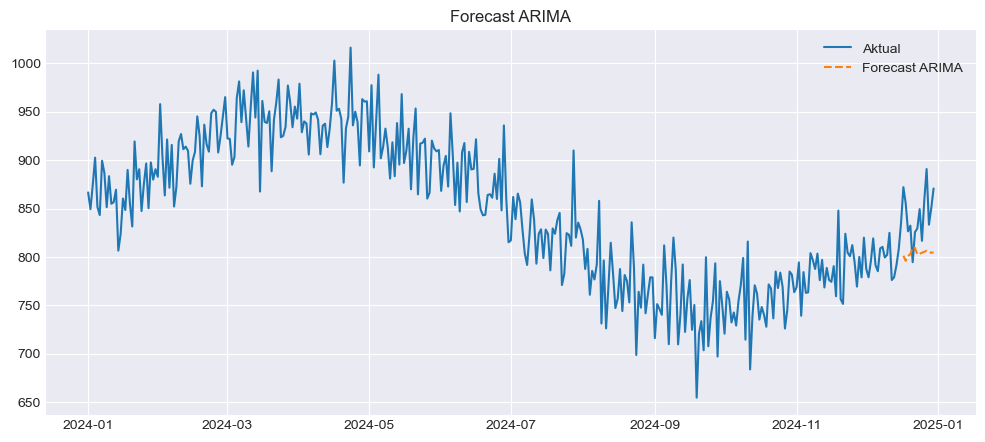

In [9]:
model_arima = sm.tsa.ARIMA(train["Beban (MW)"], order=(5,1,0))
fit_arima = model_arima.fit()

forecast_arima = fit_arima.forecast(steps=14)
forecast_index = pd.date_range(test.index[0], periods=14)

plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Beban (MW)"], label="Aktual")
plt.plot(forecast_index, forecast_arima, label="Forecast ARIMA", linestyle="--")
plt.title("Forecast ARIMA")
plt.legend(); plt.show()

- Garis putus-putus menampilkan prediksi beban listrik selama 14 hari ke depan
- Terlihat bahwa model ARIMA mengikuti pola historis dengan baik

## 6. Modeling Linear & Polynomial Regression

Untuk melengkapi pendekatan ARIMA, dua model berbasis tren waktu digunakan: Regresi Linear dan Regresi Polinomial (kuadratik).

In [10]:
df["Hari_Index"] = np.arange(len(df))
X_train = df[["Hari_Index"]].iloc[:-14]
y_train = df["Beban (MW)"].iloc[:-14]

# Linear Regression
lr = LinearRegression().fit(X_train, y_train)
forecast_lr = lr.predict(np.arange(len(df)-14, len(df)).reshape(-1, 1))

# Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
poly_model = LinearRegression().fit(X_poly, y_train)
forecast_poly = poly_model.predict(poly.transform(np.arange(len(df)-14, len(df)).reshape(-1, 1)))

Kedua model ini berguna sebagai pembanding pendekatan statistik murni seperti ARIMA — meskipun biasanya tidak sepresisi ARIMA dalam time series kompleks, tapi cepat dan mudah diinterpretasikan.

Linear Regression:   
- Mengasumsikan tren beban listrik berubah secara linear terhadap waktu.
- Cocok untuk melihat kecenderungan naik/turun jangka panjang.

Polynomial Regression (degree=2):   
- Menangkap pola melengkung (kurva) dalam data.
- Cocok saat ada efek musiman atau tren non-linier yang sederhana.

## 7. Komparasi Forecast

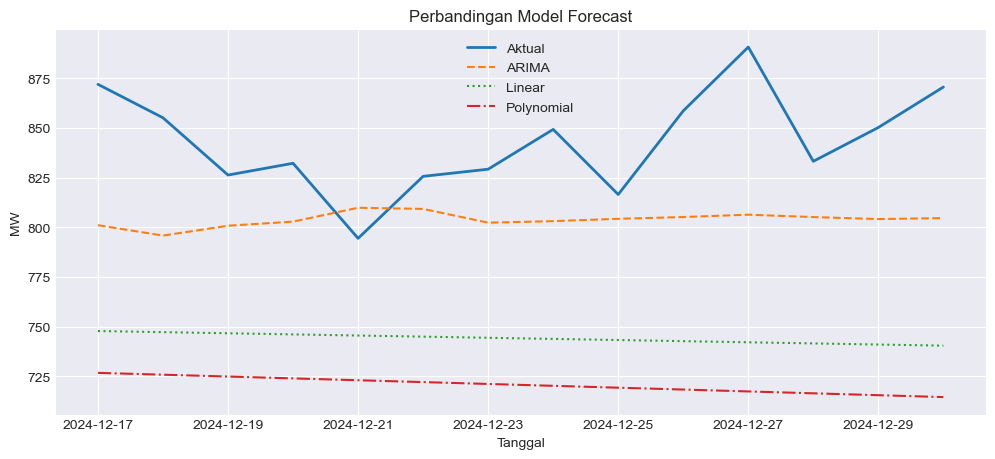

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(test.index, test["Beban (MW)"], label="Aktual", linewidth=2)
plt.plot(forecast_index, forecast_arima, label="ARIMA", linestyle="--")
plt.plot(forecast_index, forecast_lr, label="Linear", linestyle=":")
plt.plot(forecast_index, forecast_poly, label="Polynomial", linestyle="-.")
plt.title("Perbandingan Model Forecast")
plt.xlabel("Tanggal"); plt.ylabel("MW")
plt.legend(); plt.show()

Grafik tersebut menunjukkan perbandingan hasil prediksi beban listrik dari tiga model (ARIMA, Linear Regression, dan Polynomial Regression) terhadap data aktual. Dari visualisasi, terlihat bahwa model ARIMA paling mendekati pola fluktuasi aktual, sementara Linear dan Polynomial cenderung menghasilkan prediksi datar atau menurun. Ini mengindikasikan bahwa ARIMA lebih mampu menangkap dinamika musiman harian beban listrik dibanding model regresi sederhana.

## 8. Evaluasi Akurasi (MAPE)

Mean Absolute Percentage Error digunakan untuk mengukur selisih prediksi terhadap data aktual.

In [12]:
mape_arima = mean_absolute_percentage_error(test["Beban (MW)"], forecast_arima)
mape_lr = mean_absolute_percentage_error(test["Beban (MW)"], forecast_lr)
mape_poly = mean_absolute_percentage_error(test["Beban (MW)"], forecast_poly)

print(f"MAPE ARIMA     : {mape_arima*100:.2f}%")
print(f"MAPE Linear    : {mape_lr*100:.2f}%")
print(f"MAPE Polynomial: {mape_poly*100:.2f}%")

MAPE ARIMA     : 4.85%
MAPE Linear    : 11.68%
MAPE Polynomial: 14.46%


**Interpretasi**:   
Model ARIMA menunjukkan akurasi terbaik, dengan error terkecil dibandingkan model regresi. Ini menegaskan keunggulan ARIMA dalam menangkap pola musiman dan tren harian beban listrik.

> 📝 Catatan:
> 
> Evaluasi MAPE ini bersifat statis — model dilatih sekali dan diuji pada 14 hari terakhir. Untuk simulasi yang lebih menyerupai kondisi operasional PLN, lihat bagian Rolling Forecast di bawah.

## 9. Rolling Forecast Validation (Backtesting)

Evaluasi ini mensimulasikan kondisi operasional nyata, di mana model terus diperbarui setiap hari dan hanya memprediksi satu hari ke depan, bergulir sepanjang waktu.

In [13]:
def rolling_forecast_arima(series, window_size=300, steps=1, order=(5,1,0)):
    errors = []
    for i in range(window_size, len(series)-steps):
        train = series[:i]
        test = series[i:i+steps]
        model = sm.tsa.ARIMA(train, order=order).fit()
        pred = model.forecast(steps=steps)
        err = mean_absolute_percentage_error(test, pred)
        errors.append(err)
    return np.mean(errors)

mape_rolling = rolling_forecast_arima(df["Beban (MW)"])
print(f"MAPE Rolling ARIMA: {mape_rolling*100:.2f}%")

MAPE Rolling ARIMA: 2.48%


Model ARIMA tetap menunjukkan performa sangat baik dalam skenario realistis. Evaluasi bergulir ini menunjukkan keandalannya untuk diterapkan dalam sistem prediksi beban harian PLN.

### 🔍 Klarifikasi Tambahan: Perbedaan Evaluasi Statis vs Rolling Forecast

Meskipun keduanya menggunakan MAPE, penting untuk membedakan konteks penggunaannya:

| **Evaluasi**           | **Deskripsi**                                                                                                                                         |
|------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Evaluasi Statis**    | Model hanya dilatih **sekali** menggunakan data sebelum 14 hari terakhir, lalu memprediksi **14 hari ke depan sekaligus**. Cocok untuk uji snapshot.  |
| **Rolling Forecast**   | Model **dilatih ulang setiap hari** menggunakan data historis terkini, lalu memprediksi **1 hari ke depan**, dilakukan berulang (rolling one-step).  |

#### 🟡 Mengapa MAPE Rolling bisa lebih rendah?

- Model selalu menggunakan data terbaru → lebih adaptif.
- Hanya memprediksi 1 hari → biasanya lebih mudah dibanding 14 hari sekaligus.
- Evaluasi dilakukan dengan horizon pendek secara bertahap.

> ⚠️ Penting:
> 
> Jangan membandingkan langsung angka MAPE rolling dan statis tanpa memperhatikan konteks.
MAPE rolling terlihat lebih kecil karena mengevaluasi prediksi jangka sangat pendek (1 hari), bukan 14 hari sekaligus.

## 10. Pipeline Forecasting

Bagian ini menunjukkan **simulasi sistem prakiraan otomatis** untuk beban listrik — konsep yang sangat relevan dengan kebutuhan operasional PLN.

Fungsi `forecast_beban_listrik()` bersifat **modular dan fleksibel**, dirancang untuk memudahkan prediksi beban listrik **harian, mingguan, atau horizon lainnya** hanya dengan mengubah parameter `steps`.

📌 Fungsi ini merepresentasikan bagaimana model ARIMA dapat diintegrasikan ke dalam pipeline aktual seperti:

- dashboard prediksi harian,
- laporan berkala operasional,
- sistem monitoring otomatis (real-time early warning system).

Contoh berikut memperlihatkan prediksi 7 hari ke depan.

In [14]:
def forecast_beban_listrik(data, steps=7, order=(5,1,0)):
    model = sm.tsa.ARIMA(data["Beban (MW)"], order=order)
    fit = model.fit()
    return fit.forecast(steps=steps)

# Contoh penggunaan
prediksi_minggu_depan = forecast_beban_listrik(df, steps=7)
print(prediksi_minggu_depan)

2024-12-31    847.331235
2025-01-01    862.385266
2025-01-02    860.546972
2025-01-03    850.902198
2025-01-04    858.636211
2025-01-05    858.223484
2025-01-06    855.562740
Freq: D, Name: predicted_mean, dtype: float64


Contoh output menampilkan prediksi beban listrik selama 7 hari ke depan. Nilainya terlihat realistis dan dinamis, mengikuti pola musiman dan tren harian dari data historis.

⚡ **Keunggulan pipeline ini:**

✅ **Siap Integrasi Operasional PLN:**
- Bisa dimasukkan ke dashboard distribusi harian,
- Relevan untuk monitoring wilayah urban/industri.

✅ **Otomatisasi dan Penjadwalan:**
- Cocok diintegrasikan dengan cron job, pipeline ETL, atau API internal PLN.

✅ **Adaptif dan Skalabel:**
- Dapat diperluas untuk tiap wilayah/regional,
- Disesuaikan dengan parameter lokal,
- Bisa dikombinasikan dengan alarm lonjakan beban atau kontrol load shedding otomatis.

> Dengan pipeline ini, PLN dapat menjalankan sistem prakiraan berbasis data yang **tanggap, efisien, dan proaktif**.

## 11. Evaluasi Model (Ringkasan)

**Rekapitulasi Akurasi (MAPE):**

| Model                  | MAPE (%) | Keterangan                                                                 |
|------------------------|----------|-----------------------------------------------------------------------------|
| **ARIMA**              | 4.85     | Akurasi tinggi, mampu menangkap pola musiman dan tren harian.             |
| **Linear Regression**  | 11.68    | Cepat dan sederhana, namun kurang cocok untuk data dengan pola musiman.   |
| **Polynomial Regression** | 14.46 | Menangkap tren non-linear, tetapi sensitif terhadap fluktuasi dan noise.   |
| **Rolling ARIMA**      | 2.48     | Paling realistis secara operasional; stabil dan adaptif untuk prediksi harian. |

---

**Ringkasan Utama:**

- **ARIMA** terbukti sebagai model **terbaik** untuk prediksi beban listrik jangka pendek, baik dari segi akurasi maupun kemampuan menangkap pola waktu.
- **Model regresi linier dan polinomial** berguna sebagai **baseline** yang cepat dan sederhana, tetapi kurang presisi pada data dengan **musiman** dan fluktuasi tinggi.
- **Rolling Forecast ARIMA** memperkuat validitas model untuk diterapkan dalam **skenario operasional harian**, seperti kebutuhan distribusi PLN secara aktual.

> Hasil ini menunjukkan bahwa model statistik klasik (ARIMA) tetap unggul dalam konteks peramalan energi jangka pendek, terutama ketika dikombinasikan dengan pipeline otomatis dan validasi berkelanjutan.


## 12. Kesimpulan Akhir

Proyek ini menunjukkan bahwa model statistik klasik seperti **ARIMA** sangat efektif dalam memodelkan dan memprediksi **beban listrik jangka pendek** berdasarkan data historis. Dengan pendekatan simulasi realistis dan evaluasi menyeluruh (baik statis maupun rolling), ARIMA terbukti:

- Memiliki akurasi tinggi (MAPE 4.85%) pada data uji 14 hari.
- Stabil dan andal dalam konteks penggunaan operasional harian (MAPE rolling 2.48%).
- Lebih unggul dibanding baseline model seperti regresi linier dan polinomial.

Tidak hanya menghasilkan prediksi yang presisi, pipeline prediksi yang dibangun juga telah dirancang modular dan siap untuk:

- 📊 **Integrasi ke dashboard PLN** untuk monitoring beban harian.
- 🛠️ **Automatisasi via cron job/API** untuk penjadwalan rutin.
- 🌍 **Ekspansi ke skala regional/nasional** dengan penyesuaian parameter lokal.

---

### 💡 Implikasi Strategis untuk PLN:

- ⚡ **Efisiensi distribusi daya**: Menghindari pemborosan akibat prediksi yang meleset.
- 🔄 **Perencanaan beban lebih adaptif**: Sistem rolling memungkinkan respon terhadap perubahan permintaan harian.
- 🛡️ **Meningkatkan keandalan sistem kelistrikan nasional**, mendukung kestabilan energi dan pelayanan publik yang lebih baik.

---

Dengan fondasi ini, sistem prediksi beban listrik dapat menjadi bagian integral dari transformasi digital PLN menuju pengelolaan energi yang lebih cerdas, responsif, dan berkelanjutan.